In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from casting.configuration import paths, columns, params
from casting.preprocessing import (
                                   drop_null, 
                                   split_by_dbscan,
                                   remove_outlier,
                                   save_scaler,
                                   save_label_encoding)
from casting.utils import load_data


from casting.trainner import train_xgboost, train_lightgbm, train_extra_trees, train_tabnet, train_FTT, FttDataloader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


from torch.utils.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print('devece:', device)
print('torch version:', torch.__version__)

import pandas as pd
pd.set_option('display.max_columns', None) ## 모든 열을 출력한다
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_manager.fontManager.addfont('NanumGothic-Bold.ttf')
plt.rc('font', family='NanumGothic')

cuda
True
devece: cuda
torch version: 2.0.1+cu117


In [2]:
data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')
data = data_origin[columns.use_columns]

# Preprocessing

### base

In [3]:
## null 값 제외
data = drop_null(data).reset_index(drop=True)
## 이상치 제거
data = remove_outlier(data)


if params.model_name == 'FTT':
    ## 스케일러 생성
    save_scaler(data, 
                columns.numeric_columns, 
                columns.target_column,
                paths.X_scaler_path,
                paths.y_scaler_path
                )
    ## 카테고리 컬럼 처리를 위한 라벨 인코딩
    save_label_encoding(data, columns.category_columns, paths.label_encoding_path)

    split_by_dbscan(data, 'casting/data/scaled_data/')
else :
    ## 데이터 분리
    split_by_dbscan(data, 'casting/data/processed_data/')

# Predictor

### load_data

In [4]:
train, valid, test = load_data(params.model_name)

### Modeling

In [5]:
## TODO : 모듈 형식으로 모델 GATEWAY 함수 구성
## TODO : AUTO ML 넣어서 제일 좋은 성능을 Select하는 형식

if params.model_name == 'LGBM' :
    model = train_lightgbm(train, valid)
elif params.model_name == 'XGB' :
    model = train_xgboost(train, valid)
elif params.model_name == 'EXT' :
    model = train_extra_trees(train, valid)
elif params.model_name == 'TABNET' :
    model = train_tabnet(train, valid)
## GPU 환경 필수
elif params.model_name == 'FTT' :
    model = train_FTT(train, valid)

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Number of positive: 2586, number of negative: 59825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 62411, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041435 -> initscore=-3.141311
[LightGBM] [Info] Start training from score -3.141311


### inference

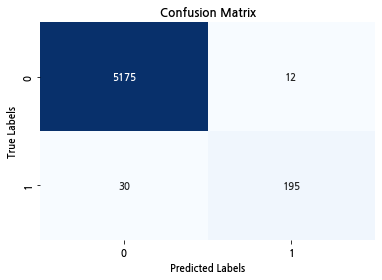

F1 Score: 0.9028
accuracy_score: 0.9922
precision_score: 0.9420
recall_score: 0.8667


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# 혼동 행렬 계산

## FTT 모델일때 inference
if params.model_name == 'FTT' :
    test_data = FttDataloader(test)
    test_loader = DataLoader(test_data, batch_size=len(test), shuffle=False)

    model.to(device)
    model.eval()
    all_pred = []
    all_y = []
    x_samples = []
    with torch.no_grad():
        cul_loss = 0  # SE
        count = 0
        for batch, (x_categ, x_numer, y) in enumerate(test_loader):
            x_categ, x_numer, y = x_categ.to(device), x_numer.to(device), y.to(device)
            # 예측 오류 계산
            pred = model(x_categ, x_numer)
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            all_pred.extend(pred)
            all_y.extend(y)

    all_pred = np.array(all_pred)
    all_y = np.array(all_y)

    y_test = pd.DataFrame(np.array(all_y)) 
    y_pred = pd.DataFrame(np.array(all_pred)).round(1).astype(int)
## 그외 모델일때
else :

    X_test, y_test = test[columns.input_columns], test[columns.target_column]
    

    y_pred = model.predict(X_test.values)
    test_cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 계산
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 점수 계산
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

acc = accuracy_score(y_test, y_pred)
print(f'accuracy_score: {acc:.4f}')

ps = precision_score(y_test, y_pred)
print(f'precision_score: {ps:.4f}')

rs = recall_score(y_test, y_pred)
print(f'recall_score: {rs:.4f}')


# Postprocessing

## 유민님 작업 공간

# Prescriptor

## Simulated Annealing

In [9]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Optional
import pandas as pd
from ipypb import ipb

@dataclass
class OptimizationConfig:
    initial_temp: float = 1000.0
    cooling_rate: float = 0.999
    max_iterations: int = 10000
    neighbor_range_threshold: float = 0.5

class SimulatedAnnealing:
    def __init__(
        self,
        model,
        columns,
        config: OptimizationConfig = OptimizationConfig()
    ):
        self.model = model
        self.columns = columns
        self.config = config
        self.reset_parameters()

    def reset_parameters(self):
        """initialization"""
        self.best_solution = None
        self.best_energy = float('inf')
        self.current_solution = None
        self.current_energy = float('inf')
        self.init_solution = None
        self.init_energy = float('inf')

    def initialize_context(self, test_data: pd.DataFrame) -> pd.DataFrame:
        """context initialization"""
        initial_values = {
            'lower_mold_temp2': test_data['lower_mold_temp2'].mean(),
            'cast_pressure': test_data['cast_pressure'].mean(),
            'molten_temp': test_data['molten_temp'].mean()
        }
        
        df = test_data[self.columns.context_columns].copy()
        for col, val in initial_values.items():
            df[col] = val
            
        return df

    def objective_function(self, solution: np.ndarray, X_input: pd.DataFrame) -> float:
        """Objective function"""
        X_modified = X_input.copy()

        # 컬럼별로 다른 값을 더해줘야 함
        X_modified['lower_mold_temp2'] += solution.T[0]
        X_modified['cast_pressure'] += solution.T[1]
        X_modified['molten_temp'] += solution.T[2]
        return self.model.predict(X_modified).mean()

    def generate_neighbor(
        self, 
        current: np.ndarray, 
        temp: float, 
        initial_temp: float
    ) -> np.ndarray:
        """Neighbor generation"""
        neighbor_range = (temp / initial_temp) * 20
        return current + np.random.normal(-neighbor_range, neighbor_range, (len(current),3)) # 3개의 컬럼에 대해 노이즈 추가

    def optimize(
        self, 
        test_data: pd.DataFrame, 
        progress_callback: Optional[callable] = None
    ) -> Tuple[np.ndarray, float, np.ndarray, float]:

        """Optimization"""
        df = self.initialize_context(test_data)
        X_test = df[self.columns.input_columns]

        # 초기 해 설정
        self.current_solution = np.random.randint(-3, 3, (len(X_test),3)) # 3개의 컬럼에 대해 랜덤 초기값 설정
        self.current_energy = self.objective_function(self.current_solution, X_test)
        
        # 초기값 저장
        self.init_solution = self.current_solution.copy()
        self.init_energy = self.objective_function(self.init_solution, X_test)
        
        # 최적값 초기화
        self.best_solution = self.current_solution.copy()
        self.best_energy = self.init_energy
        
        temp = self.config.initial_temp

        for iteration in ipb(range(self.config.max_iterations)):
            # neighbor solution generation
            new_solution = self.generate_neighbor(
                self.current_solution, 
                temp, 
                self.config.initial_temp
            )
            new_energy = self.objective_function(new_solution, X_test)

            # neighbor solution accept
            neighbor_range = (temp / self.config.initial_temp) * 20
            if neighbor_range < self.config.neighbor_range_threshold:
                break

            # solution update
            if new_energy < self.current_energy:
                self.current_solution = new_solution
                self.current_energy = new_energy

                if self.current_energy < self.best_energy:
                    self.best_solution = self.current_solution.copy()
                    self.best_energy = self.current_energy
                    print(f'Best energy updated: {self.best_energy}')

            # temp cooling
            temp *= self.config.cooling_rate

            # callback
            if progress_callback:
                progress_callback(iteration, self.best_energy)

        return (
            self.init_solution,
            self.init_energy,
            self.best_solution,
            self.best_energy
        )
    

# callback function 
def progress_callback(iteration: int, best_energy: float):
    if iteration % 1000 == 0:
        print(f"Iteration {iteration}: Best Energy = {best_energy}")

In [11]:
# optimize
config = OptimizationConfig(
    initial_temp=1000,
    cooling_rate=0.999,
    max_iterations=10000,
    neighbor_range_threshold=0.5
)

optimizer = SimulatedAnnealing(model, columns, config)

init_solution, init_energy, best_solution, best_energy = optimizer.optimize(
    test,
    progress_callback=progress_callback
)

print(f"초기해: {init_solution}, 초기 에너지: {init_energy}")
print(f"최적해: {best_solution}, 최적 에너지: {best_energy}")

 [██████████████████████######################################] 3678/10000 [00:31<00:00, 0.01s/it]

Iteration 0: Best Energy = 0.01977087952697709
Iteration 1000: Best Energy = 0.01977087952697709
Iteration 2000: Best Energy = 0.01977087952697709
Iteration 3000: Best Energy = 0.01977087952697709
Best energy updated: 0.01958610495195861
초기해: [[ 2  1  2]
 [-3 -2 -2]
 [-3 -3 -1]
 ...
 [ 2  0 -1]
 [-3  0  0]
 [ 0  0 -1]], 초기 에너지: 0.01977087952697709
최적해: [[ 5.31348909e-04 -1.40604235e+00  4.56221440e-01]
 [-2.72858104e+00 -4.05738592e+00 -6.37748789e+00]
 [-2.78534693e+00 -4.05665052e+00 -1.69391941e+00]
 ...
 [-7.47428552e-01 -7.34917621e-02 -1.34633196e+00]
 [-4.78265763e+00 -4.28917573e-03 -8.30277800e-01]
 [ 3.88877984e-01 -8.43948872e-01 -1.54047078e+00]], 최적 에너지: 0.01958610495195861


In [12]:
## 최적화 결과 비교

X_test_origin, y_test = test[columns.input_columns], test[columns.target_column]
X_test = X_test_origin.copy()

X_test['lower_mold_temp2'] += optimizer.best_solution.T[0]
X_test['cast_pressure'] += optimizer.best_solution.T[1]
X_test['molten_temp'] += optimizer.best_solution.T[2]

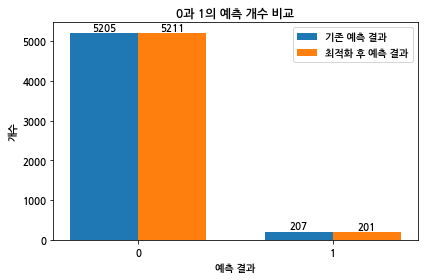

In [13]:
# 예측 결과 생성
pred_origin = model.predict(X_test_origin)  # 기존 예측 결과
pred_test = model.predict(X_test)  # 새로운 예측 결과

# 각 예측 결과에서 0과 1의 개수 계산
count_origin = [np.sum(pred_origin == 0), np.sum(pred_origin == 1)]
count_test = [np.sum(pred_test == 0), np.sum(pred_test == 1)]

# 막대 그래프 데이터 준비
labels = ['0', '1']
x = np.arange(len(labels))  # x축 위치

# 그래프 그리기
width = 0.35  # 막대 너비

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, count_origin, width, label='기존 예측 결과')
bars2 = ax.bar(x + width/2, count_test, width, label='최적화 후 예측 결과')

# 라벨 추가
ax.set_xlabel('예측 결과')
ax.set_ylabel('개수')
ax.set_title('0과 1의 예측 개수 비교')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 각 막대에 값 표시
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Bayesian Optimization

In [14]:
from bayes_opt import BayesianOptimization

In [15]:
# bayesian optimization
def predictor_function(lower_mold_temp2, cast_pressure, molten_temp):
    X_test = test[columns.input_columns].copy()
    X_test['lower_mold_temp2'] = lower_mold_temp2
    X_test['cast_pressure'] = cast_pressure
    X_test['molten_temp'] = molten_temp
    return - model.predict(X_test).mean()

# Bounded region of parameter space
pbounds = {'lower_mold_temp2': (135, 333), 'cast_pressure': (300, 1000), 'molten_temp': (626, 735)}

optimizer = BayesianOptimization(
    f=predictor_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)


In [16]:
optimizer.maximize(
    init_points=5,
    n_iter=10,
)

|   iter    |  target   | cast_p... | lower_... | molten... |
-------------------------------------------------------------
| 1         | -0.0146   | 591.9     | 277.6     | 626.0     |
| 2         | -0.02033  | 511.6     | 164.1     | 636.1     |
| 3         | -0.01737  | 430.4     | 203.4     | 669.2     |
| 4         | -0.01774  | 677.2     | 218.0     | 700.7     |
| 5         | -0.05562  | 443.1     | 308.9     | 629.0     |
| 6         | -0.02014  | 509.3     | 165.5     | 634.5     |
| 7         | -0.05562  | 682.6     | 309.9     | 626.0     |
| 8         | -0.017    | 591.9     | 225.8     | 671.9     |
| 9         | -0.03659  | 437.9     | 141.7     | 717.7     |
| 10        | -0.01534  | 541.9     | 241.2     | 631.1     |
| 11        | -0.02033  | 627.2     | 166.2     | 629.1     |
| 12        | -0.04564  | 655.0     | 151.3     | 734.3     |
| 13        | -0.01441  | 561.6     | 285.1     | 683.0     |
| 14        | -0.01718  | 518.3     | 230.2     | 702.6     |
| 15    

In [17]:
## 최적화 결과 비교

X_test_origin, y_test = test[columns.input_columns], test[columns.target_column]
X_test = X_test_origin.copy()

X_test['lower_mold_temp2'] = optimizer.max['params']['lower_mold_temp2']
X_test['cast_pressure'] = optimizer.max['params']['cast_pressure']
X_test['molten_temp'] = optimizer.max['params']['molten_temp']


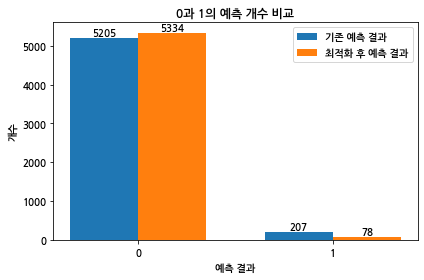

In [18]:
# 예측 결과 생성
pred_origin = model.predict(X_test_origin)  # 기존 예측 결과
pred_test = model.predict(X_test)  # 새로운 예측 결과

# 각 예측 결과에서 0과 1의 개수 계산
count_origin = [np.sum(pred_origin == 0), np.sum(pred_origin == 1)]
count_test = [np.sum(pred_test == 0), np.sum(pred_test == 1)]

# 막대 그래프 데이터 준비
labels = ['0', '1']
x = np.arange(len(labels))  # x축 위치

# 그래프 그리기
width = 0.35  # 막대 너비

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, count_origin, width, label='기존 예측 결과')
bars2 = ax.bar(x + width/2, count_test, width, label='최적화 후 예측 결과')

# 라벨 추가
ax.set_xlabel('예측 결과')
ax.set_ylabel('개수')
ax.set_title('0과 1의 예측 개수 비교')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 각 막대에 값 표시
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
## Bayesian Optimization 하이퍼 파라미터 찾기

init_points: 3, n_iter: 10
Average Score: -0.0144 (±0.0000)
--------------------------------------------------
init_points: 3, n_iter: 20
Average Score: -0.0144 (±0.0000)
--------------------------------------------------
init_points: 3, n_iter: 30
Average Score: -0.0144 (±0.0000)
--------------------------------------------------
init_points: 3, n_iter: 40
Average Score: -0.0144 (±0.0000)
--------------------------------------------------
init_points: 3, n_iter: 50
Average Score: -0.0144 (±0.0000)
--------------------------------------------------
init_points: 5, n_iter: 10
Average Score: -0.0143 (±0.0002)
--------------------------------------------------
init_points: 5, n_iter: 20
Average Score: -0.0143 (±0.0002)
--------------------------------------------------
init_points: 5, n_iter: 30
Average Score: -0.0143 (±0.0002)
--------------------------------------------------
init_points: 5, n_iter: 40
Average Score: -0.0143 (±0.0002)
--------------------------------------------------
i

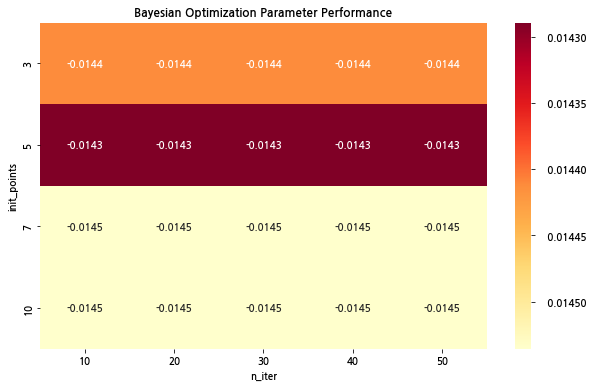

In [19]:
from itertools import product

def evaluate_bo_params(init_points, n_iter, random_state=1):
    """
    bayesian optimization eval
    """
    optimizer = BayesianOptimization(
        f=predictor_function,
        pbounds=pbounds,
        verbose=0,
        random_state=random_state
    )
    
    # bayesian optimization
    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter
    )
    
    return optimizer.max['target']

# parameter seraech range
init_points_range = [3, 5, 7, 10]
n_iter_range = [10, 20, 30, 40, 50]

# 결과 저장 dic
results = {}

# Grid Search 
for init_points, n_iter in product(init_points_range, n_iter_range):
    # 각 조합에 대해 여러 번 실행하여 평균 성능 계산
    scores = []
    for seed in range(3):  # 3번 반복
        score = evaluate_bo_params(init_points, n_iter, random_state=seed)
        scores.append(score)
    
    # save average score
    avg_score = np.mean(scores)
    std_score = np.std(scores)
    results[(init_points, n_iter)] = (avg_score, std_score)
    
    print(f"init_points: {init_points}, n_iter: {n_iter}")
    print(f"Average Score: {avg_score:.4f} (±{std_score:.4f})")
    print("-" * 50)

# hp search
best_params = max(results.items(), key=lambda x: x[1][0])
print("\nBest Parameters:")
print(f"init_points: {best_params[0][0]}")
print(f"n_iter: {best_params[0][1]}")
print(f"Score: {best_params[1][0]:.4f} (±{best_params[1][1]:.4f})")


# heatmap 
heatmap_data = np.zeros((len(init_points_range), len(n_iter_range)))
for i, init_points in enumerate(init_points_range):
    for j, n_iter in enumerate(n_iter_range):
        heatmap_data[i, j] = results[(init_points, n_iter)][0]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, 
            xticklabels=n_iter_range,
            yticklabels=init_points_range,
            annot=True,
            fmt='.4f',
            cmap='YlOrRd')
plt.xlabel('n_iter')
plt.ylabel('init_points')
plt.title('Bayesian Optimization Parameter Performance')
plt.show()

# Multi-Objective Bayesian Optimization

In [22]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from typing import Dict, List, Tuple, Optional, Any

class MultiObjectiveOptimizer:
    def __init__(
        self,
        model: Any,
        columns: Any,
        bounds: Dict[str, Tuple[float, float]],
        obj_weights: Optional[Dict[str, float]] = None
    ):
        if not hasattr(model, 'predict'):
            raise ValueError("Model must have a predict method")
            
        self.model = model
        self.columns = columns
        self.bounds = bounds
        self.param_names = list(bounds.keys())
        
        if obj_weights is None:
            self.obj_weights = {
                'prediction': 1.0,
                'lower_mold_temp2': -0.3,
                'cast_pressure': -0.3,
                'molten_temp': -0.3
            }
        else:
            required_keys = {'prediction', 'lower_mold_temp2', 'cast_pressure', 'molten_temp'}
            if not all(key in obj_weights for key in required_keys):
                raise ValueError(f"obj_weights must contain all keys: {required_keys}")
            self.obj_weights = obj_weights
            
        if not all(isinstance(v, tuple) and len(v) == 2 and v[0] <= v[1] for v in bounds.values()):
            raise ValueError("All bounds must be tuples of (min, max) where min <= max")
            
        self.bounds_tensor = torch.tensor([
            [bounds[name][0] for name in self.param_names],
            [bounds[name][1] for name in self.param_names]
        ], dtype=torch.float64)
        
        self.X: List[torch.Tensor] = []
        self.Y: List[torch.Tensor] = []
        self.test_data: Optional[pd.DataFrame] = None

    def evaluate_objectives(self, x: torch.Tensor) -> torch.Tensor:
        if self.test_data is None:
            raise RuntimeError("test_data must be set before calling evaluate_objectives")
            
        x_np = x.numpy()
        n_points = x_np.shape[0]
        objectives = torch.zeros((n_points, 4), dtype=torch.float64)
        
        for i in range(n_points):
            try:
                X_test = self.test_data[self.columns.input_columns].copy()
                X_test['lower_mold_temp2'] = x_np[i, 0]
                X_test['cast_pressure'] = x_np[i, 1]
                X_test['molten_temp'] = x_np[i, 2]
                pred = -self.model.predict(X_test).mean()
                
                objectives[i, 0] = pred * self.obj_weights['prediction']
                objectives[i, 1] = -x_np[i, 0] * self.obj_weights['lower_mold_temp2']
                objectives[i, 2] = -x_np[i, 1] * self.obj_weights['cast_pressure']
                objectives[i, 3] = -x_np[i, 2] * self.obj_weights['molten_temp']
                
            except Exception as e:
                raise RuntimeError(f"Error evaluating objectives at point {i}: {str(e)}")
            
        return objectives

    def initialize_model(self, train_x: torch.Tensor, train_obj: torch.Tensor):
        model = SingleTaskGP(train_x, train_obj)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        return model

    def get_pareto_front(self, Y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """pareto front 계싼"""
        Y_tensor = Y if isinstance(Y, torch.Tensor) else torch.tensor(Y, dtype=torch.float64)
        is_pareto = torch.ones(len(Y_tensor), dtype=torch.bool)
        
        for i in range(len(Y_tensor)):
            for j in range(len(Y_tensor)):
                if i != j:
                    if all(Y_tensor[j] >= Y_tensor[i]) and any(Y_tensor[j] > Y_tensor[i]):
                        is_pareto[j] = False
                        
        return is_pareto

    def optimize(
        self,
        test_data: pd.DataFrame,
        n_initial: int = 10,
        n_iterations: int = 50
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        self.test_data = test_data
        
        # initial random sampling
        print("Performing initial random sampling...")
        for _ in range(n_initial):
            x = torch.rand(1, len(self.param_names), dtype=torch.float64)
            x = x * (self.bounds_tensor[1] - self.bounds_tensor[0]) + self.bounds_tensor[0]
            obj = self.evaluate_objectives(x)
            self.X.append(x)
            self.Y.append(obj)
            
        X = torch.cat(self.X)
        Y = torch.cat(self.Y)
        
        print("\nStarting Bayesian Optimization...")
        for i in range(n_iterations):
            print(f"\nIteration {i+1}/{n_iterations}")
            
            # GP 모델 학습
            model = self.initialize_model(X, Y)
            
            # Reference point 계산
            Y_tensor = Y if isinstance(Y, torch.Tensor) else torch.tensor(Y, dtype=torch.float64)
            ref_point = Y_tensor.min(dim=0).values - 0.1
            
            # pareto front 계싼
            pareto_mask = self.get_pareto_front(Y_tensor)
            pareto_Y = Y_tensor[pareto_mask]
            
            # acq optimization
            acq_func = ExpectedHypervolumeImprovement(
                model=model,
                ref_point=ref_point,
                partitioning=FastNondominatedPartitioning(ref_point=ref_point, Y=Y_tensor)
            )
            
            new_x, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=self.bounds_tensor,
                q=1,
                num_restarts=20,
                raw_samples=100
            )
            
            new_obj = self.evaluate_objectives(new_x)
            
            X = torch.cat([X, new_x])
            Y = torch.cat([Y, new_obj])
            
            # current pareto front 계산
            pareto_mask = self.get_pareto_front(Y)
            pareto_X = X[pareto_mask]
            pareto_Y = Y[pareto_mask]
            
            print("\nCurrent Pareto frontier:")
            self._print_solutions(pareto_X, pareto_Y)
        
        return self._create_result_dataframes(pareto_X, pareto_Y)

    def _print_solutions(self, X: torch.Tensor, Y: torch.Tensor):
        for i in range(len(X)):
            print(f"\nSolution {i+1}:")
            print(f"Parameters:")
            for j, name in enumerate(self.param_names):
                print(f"  {name}: {X[i,j]:.2f}")
            print(f"Objectives:")
            print(f"  Prediction: {Y[i,0]/self.obj_weights['prediction']:.4f}")
            print(f"  Lower mold temp: {-Y[i,1]/self.obj_weights['lower_mold_temp2']:.2f}")
            print(f"  Cast pressure: {-Y[i,2]/self.obj_weights['cast_pressure']:.2f}")
            print(f"  Molten temp: {-Y[i,3]/self.obj_weights['molten_temp']:.2f}")
    
    def _create_result_dataframes(
        self,
        X: torch.Tensor,
        Y: torch.Tensor
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        x_dict = {
            name: X[:, i].numpy()
            for i, name in enumerate(self.param_names)
        }
        x_df = pd.DataFrame(x_dict)
        
        y_dict = {
            'prediction': Y[:, 0].numpy() / self.obj_weights['prediction'],
            'lower_mold_temp2': -Y[:, 1].numpy() / self.obj_weights['lower_mold_temp2'],
            'cast_pressure': -Y[:, 2].numpy() / self.obj_weights['cast_pressure'],
            'molten_temp': -Y[:, 3].numpy() / self.obj_weights['molten_temp']
        }
        y_df = pd.DataFrame(y_dict)
        
        return x_df, y_df

In [24]:
bounds = {
    'lower_mold_temp2': (135, 333),
    'cast_pressure': (300, 1000),
    'molten_temp': (626, 735)
}

obj_weights = {
    'prediction': 1.0,
    'lower_mold_temp2': -0.3,
    'cast_pressure': -0.3,
    'molten_temp': -0.3
}

optimizer = MultiObjectiveOptimizer(model, columns, bounds, obj_weights)
x_pareto, y_pareto = optimizer.optimize(test, n_initial=10, n_iterations=50)

Performing initial random sampling...

Starting Bayesian Optimization...

Iteration 1/50

Current Pareto frontier:

Solution 1:
Parameters:
  lower_mold_temp2: 167.96
  cast_pressure: 349.28
  molten_temp: 648.87
Objectives:
  Prediction: -0.0198
  Lower mold temp: 167.96
  Cast pressure: 349.28
  Molten temp: 648.87

Solution 2:
Parameters:
  lower_mold_temp2: 310.10
  cast_pressure: 728.26
  molten_temp: 719.67
Objectives:
  Prediction: -0.0702
  Lower mold temp: 310.10
  Cast pressure: 728.26
  Molten temp: 719.67

Solution 3:
Parameters:
  lower_mold_temp2: 168.85
  cast_pressure: 318.76
  molten_temp: 708.30
Objectives:
  Prediction: -0.0268
  Lower mold temp: 168.85
  Cast pressure: 318.76
  Molten temp: 708.30

Solution 4:
Parameters:
  lower_mold_temp2: 329.18
  cast_pressure: 646.46
  molten_temp: 640.64
Objectives:
  Prediction: -0.0523
  Lower mold temp: 329.18
  Cast pressure: 646.46
  Molten temp: 640.64

Solution 5:
Parameters:
  lower_mold_temp2: 142.71
  cast_pressure: 

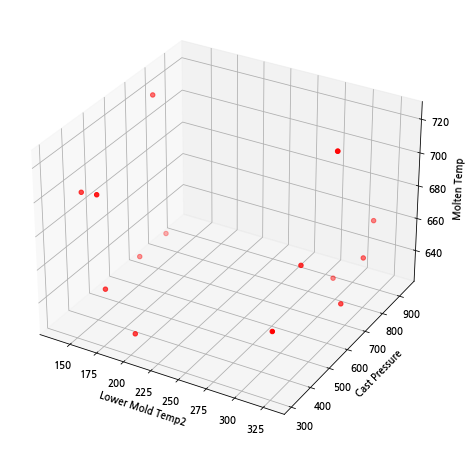

In [25]:
# 시각화
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    y_pareto['lower_mold_temp2'],
    y_pareto['cast_pressure'],
    y_pareto['molten_temp'],
    c='r', marker='o'
)

ax.set_xlabel('Lower Mold Temp2')
ax.set_ylabel('Cast Pressure')
ax.set_zlabel('Molten Temp')

plt.show()

In [26]:
x_pareto, y_pareto

(    lower_mold_temp2  cast_pressure  molten_temp
 0         167.955489     349.276666   648.868344
 1         310.098883     728.263574   719.674420
 2         168.853646     318.760886   708.296371
 3         329.180125     646.461730   640.640491
 4         142.706226     780.989652   633.157766
 5         324.439179     310.496613   660.408798
 6         305.061246     572.818274   666.999084
 7         291.047232     842.695542   627.564586
 8         141.845513     730.481267   723.415660
 9         201.107180     317.295353   632.008873
 10        310.341307     728.257490   719.793705
 11        143.640135     640.396966   633.211001
 12        320.177076     827.889778   647.627622
 13        135.683335     410.443147   694.529668
 14        311.183207     942.376068   657.212518,
     prediction  lower_mold_temp2  cast_pressure  molten_temp
 0    -0.019771        167.955489     349.276666   648.868344
 1    -0.070214        310.098883     728.263574   719.674420
 2    -0.0267

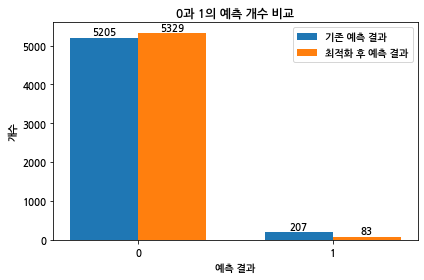

In [28]:
## 최적화 결과 비교

X_test_origin, y_test = test[columns.input_columns], test[columns.target_column]
X_test = X_test_origin.copy()

X_test['lower_mold_temp2'] = x_pareto['lower_mold_temp2'].mean()
X_test['cast_pressure'] = x_pareto['cast_pressure'].mean()
X_test['molten_temp'] = x_pareto['molten_temp'].mean()

# 예측 결과 생성
pred_origin = model.predict(X_test_origin)  # 기존 예측 결과
pred_test = model.predict(X_test)  # 새로운 예측 결과

# 각 예측 결과에서 0과 1의 개수 계산
count_origin = [np.sum(pred_origin == 0), np.sum(pred_origin == 1)]
count_test = [np.sum(pred_test == 0), np.sum(pred_test == 1)]

# 막대 그래프 데이터 준비
labels = ['0', '1']
x = np.arange(len(labels))  # x축 위치

# 그래프 그리기
width = 0.35  # 막대 너비

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, count_origin, width, label='기존 예측 결과')
bars2 = ax.bar(x + width/2, count_test, width, label='최적화 후 예측 결과')

# 라벨 추가
ax.set_xlabel('예측 결과')
ax.set_ylabel('개수')
ax.set_title('0과 1의 예측 개수 비교')
ax.set_xticks(x)

ax.set_xticklabels(labels)
ax.legend()

# 각 막대에 값 표시
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()